# Using `ipzCaptureWindow` and `ipzCaptureWindow2` for embedding graphic analysis windows into notebook

<font color='red'>**NOTE:**</font>

The current version of OpticStudio doesn't support function the function `ipzCaptureWindow()`. This is because the dataitem `GetMetaFile` has been deprecated. However, the function `ipzCaptureWindowLQ()` works fine as it uses ZPL macro to grap a snapshot of an open graphics window.

Both functions works just fine in Zemax version 13.2 and earlier.


##### **Why are there two functions for doing the same thing?**

In this notebook we explore the different use cases of the functions `ipzCaptureWindow()` and `ipzCaptureWindowLQ()`.

<font color='red'>**ipzCaptureWindowLQ()**</font>

`ipzCaptureWindowLQ()`, which takes as input a window number, uses ZPL macros to retrieve a "screenshot" from Zemax main application (note the window open in the main application is retrieved and not in the DDE server). The number is assigned by Zemax when an analysis window is opened in Zemax, and is not tied to any specific analysis. The quality of the rendered image is dependent on the quality of the JPEG image provided by Zemax. Frankly, I haven't found the quality to be any qood. The "LQ" in the name of the function indicates low-quality. For using `ipzCaptureWindowLQ()` we will also need to specify the ZPL macro path to PyZDDE.  

<font color='red'>**ipzCaptureWindow()**</font>


`ipzCaptureWindow()` generally produces better quality graphis. It takes as input the 3-letter string code for the type of analysis. It uses `zGetMetaFile()` to request ZEMAX to output a windows metafile (standard or enhanced), resizes and converts into a PNG image using ImageMagick and embeds into a notebook cell. Note that since it uses `zGetMetaFile()`, the analysis window from the DDE server is retrieved unlike in the case of `ipzCaptureWindowLQ()`. We can also ask `ipzCaptureWindow()` not to render the PNG image; instead to return the pixel array as a Numpy ndarray. We can then use any graphic rendering tool such as matplotlib to manipulate, render and annotate the graphic. This notebook mainly focuses on `ipzCaptureWindow()`.   

`ipzCaptureWindowLQ()` is much quicker than `ipzCaptureWindow()` as it doesn't have to do any intermediate image conversions. It is meant for quick interactive use (provided the ZPL macro path is provided to PyZDDE as explained later). `ipzCaptureWindow()` provides more flexibility and better quality images, though it is a little slower than `ipzCaptureWindowLQ()`.

Note that it is assumed that PyZDDE is in the Python search path.

Import PyZDDE and create a pyzdde communication object

In [1]:
import os
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz
%matplotlib inline

In [2]:
l = pyz.createLink() # create a DDE link object for communication

Load a lens file

In [3]:
zfile = os.path.join(l.zGetPath()[1], 'Sequential', 'Objectives', 'Cooke 40 degree field.zmx')
l.zLoadFile(zfile)

0

Perform a quick-focus

In [4]:
l.zQuickFocus()

0

##### Example of a Layout plot

Using `ipzCaptureWindow` to directly embed a Layout plot into the notebook.

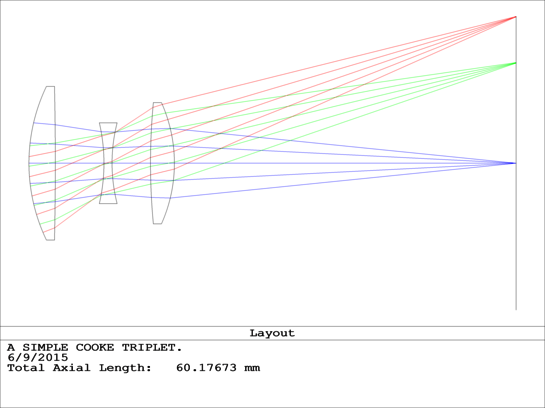

In [5]:
l.ipzCaptureWindow('Lay', percent=15, gamma=0.4)

1. ** Why do we need to set gamma? **

2. ** Is there one gamma value good for all analysis window rendering?** 


Upto Zemax13 there was no way to control othe thickness of the lines produced by ZEMAX for the metafiles. Generally the lines produced were very thin and the rescaled version would be too light to be visible. One way in which this problem was addressed is to lowpass filter the original image, rescale and then use a gamma value less than one during the conversion from metafile to PNG. This is probably not the optimal solution. One obvious side effect is that the black text becomes very thick and ugly.

Instead of embedding the figure directly, we can also get a pixel array using PyZDDE. Plotting the returned array using matplotlib may allow more control and annotation options as shown below:

In [6]:
arr = l.ipzCaptureWindow('Lay', percent=15, gamma=0.08, retArr=True)

Now that we have the pixel array, we can either use the convenience function provided in PyZDDE to make a quick plot, or make our own figure and plot as we want it.

Let's first see how we can use the convenience function, `imshow()`, provided by PyZDDE to make a cropped plot. The functions takes as input the pixel array, a tuple indicating the number of pixels to crop from the left, right, top, bottom sides of the pixel array, a tuple indicating the matplotlib figure size (optional), and a title string (optional). 

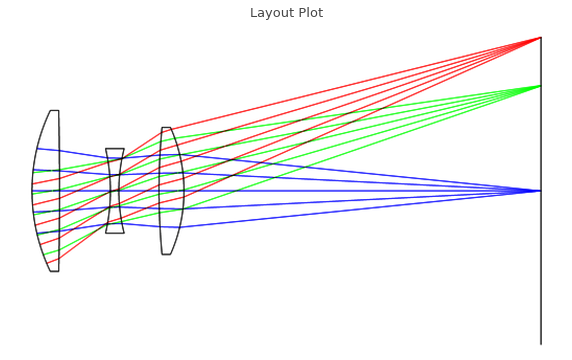

In [7]:
pyz.imshow(arr, cropBorderPixels=(5, 5, 1, 90), figsize=(10,10), title='Layout Plot')

Next, we will create a figure and direct PyZDDE to render the Layout plot in the provided figure and axes. We can then annotate the figure as we like.

But first we will get some first-order properties of the lens

In [8]:
l.ipzGetFirst()

Paraxial magnification : 0.0
Real working F/#       : 4.978219667
Effective focal length : 49.9999995
Paraxial working F/#   : 4.99999995
Paraxial image height  : 18.19851153


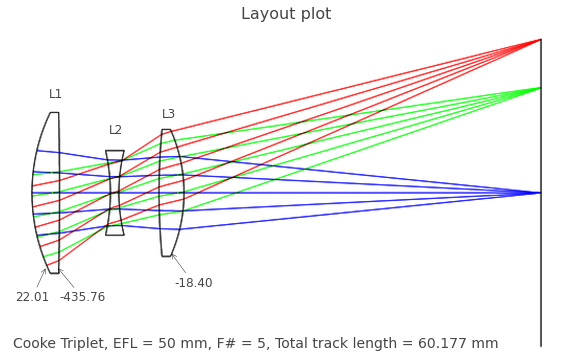

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Render the array
pyz.imshow(arr, cropBorderPixels=(5, 5, 1, 90), fig=fig, faxes=ax)

ax.set_title('Layout plot', fontsize=16)
# Annotate Lens numbers
ax.text(41, 70, "L1", fontsize=12)
ax.text(98, 105, "L2", fontsize=12)
ax.text(149, 89, "L3", fontsize=12) 

# Annotate the lens with radius of curvature information
col = (0.08,0.08,0.08)
s1_r = 1.0/l.zGetSurfaceData(1,2)
ax.annotate("{:0.2f}".format(s1_r), (37, 232), (8, 265), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col, relpos=(0.5,0.5)))
s2_r = 1.0/l.zGetSurfaceData(2,2)
ax.annotate("{:0.2f}".format(s2_r), (47, 232), (50, 265), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
s6_r = 1.0/l.zGetSurfaceData(6,2)
ax.annotate("{:0.2f}".format(s6_r), (156, 218), (160, 251), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
ax.text(5, 310, "Cooke Triplet, EFL = {} mm, F# = {}, Total track length = {} mm"
        .format(50, 5, 60.177), fontsize=14) 
plt.show()

##### Example of Ray Fan plot

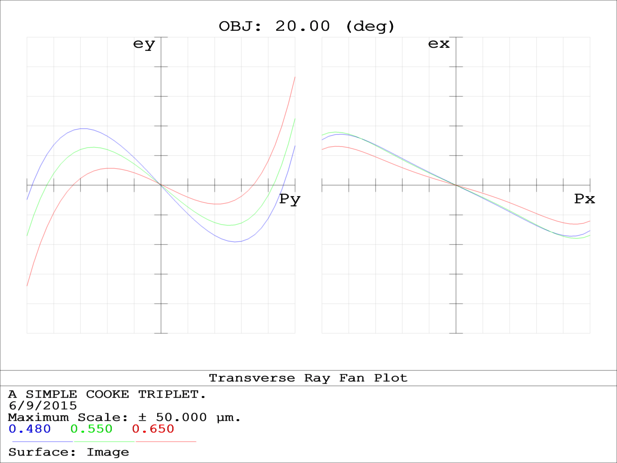

In [10]:
l.ipzCaptureWindow('Ray', percent=17, gamma=0.55)

In [11]:
rarr = l.ipzCaptureWindow('Ray', percent=25, gamma=0.15, retArr=True)

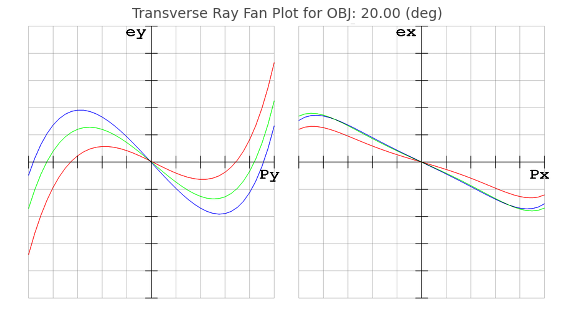

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pyz.imshow(rarr, cropBorderPixels=(5, 5, 48, 170), fig=fig, faxes=ax)
ax.set_title('Transverse Ray Fan Plot for OBJ: 20.00 (deg)', fontsize=14)
plt.show()

##### Example of Spot diagram

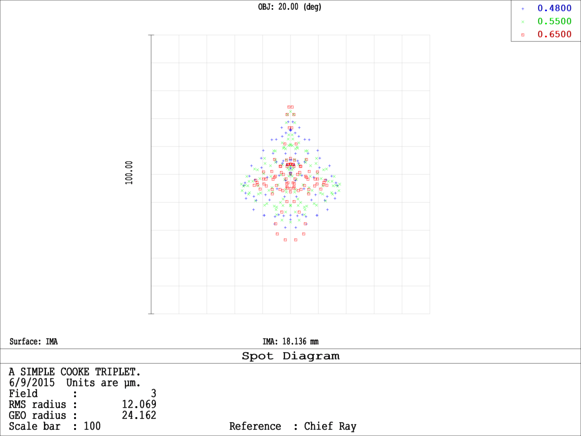

In [13]:
l.ipzCaptureWindow('Spt', percent=16, gamma=0.5)

In [14]:
sptd = l.ipzCaptureWindow('Spt', percent=25, gamma=0.15, retArr=True)

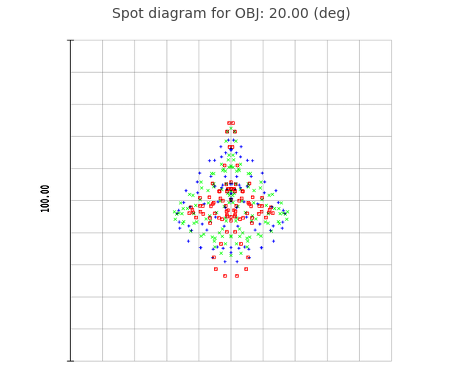

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
pyz.imshow(sptd, cropBorderPixels=(150, 150, 30, 180), fig=fig, faxes=ax)
ax.set_title('Spot diagram for OBJ: 20.00 (deg)', fontsize=14)
plt.show()

### Examples of using `ipzCaptureWindowLQ()` function in Zemax 13.2 or earlier

`ipzCaptureWindowLQ()` is useful for quickly capturing a graphic window, and embedding into an IPython notebook or QtConsole.

In order to use this function, please copy the ZPL macros from "PyZDDE\ZPLMacros" to the macro directory where Zemax is expecting the ZPL macros to be (i.e. the folder set in Zemax->Preference->Folders->ZPL).


For this particular example, the macro folder path is set to "C:\PROGRAMSANDEXPERIMENTS\ZEMAX\Macros"

In [16]:
l.zSetMacroPath(r"C:\PROGRAMSANDEXPERIMENTS\ZEMAX\Macros")

0

In [19]:
l.ipzCaptureWindowLQ(1)

Timeout reached before image file was ready.
The specified graphic window may not be open in ZEMAX!


Note that the above command didn't work, because we need to push the lens from the DDE server to the Zemax main window first. Then we also need to open each window.

In [20]:
l.zPushLens()

0

Now open the layout analysis window in Zemax. Assuming that this is the first analysis window that has been open, Zemax would have assigned the number `1` to it.

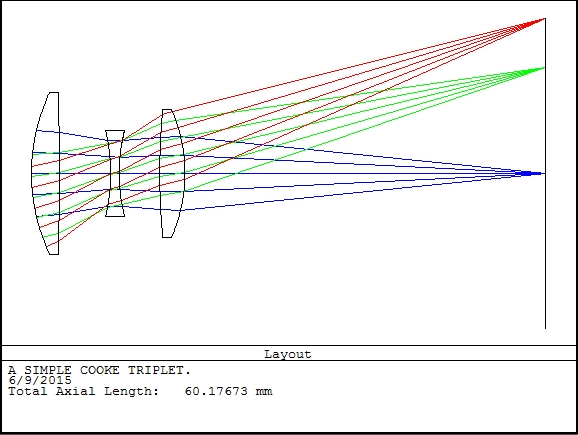

In [21]:
l.ipzCaptureWindowLQ(1)

Open the MTF analysis window in Zemax now.

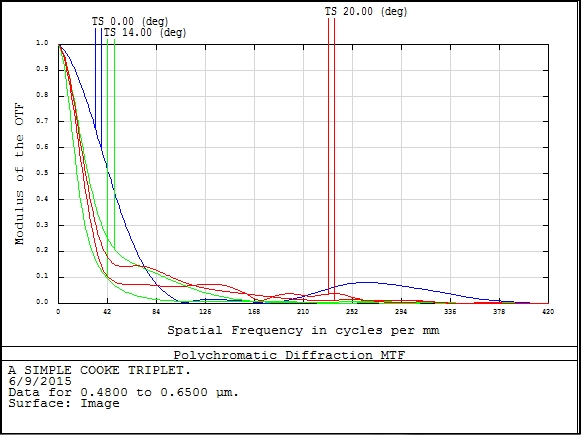

In [22]:
l.ipzCaptureWindowLQ(2)

In [23]:
pyz.closeLink()

### Examples of using `ipzCaptureWindowLQ()` function in Zemax 14 or later (OpticStudio)

In order to do this experiment, a new instance of Zemax 15 was opened, and new link created.

In [24]:
l = pyz.createLink()

In [25]:
zfile = os.path.join(l.zGetPath()[1], 'Sequential', 'Objectives', 'Cooke 40 degree field.zmx')
l.zLoadFile(zfile)

0

In [26]:
l.zPushLens()

0

In [27]:
# Set the macro path
l.zSetMacroPath(r"C:\PROGRAMSANDEXPERIMENTS\ZEMAX\Macros")

0

Now open the layout analysis window in OpticStudio as before. 

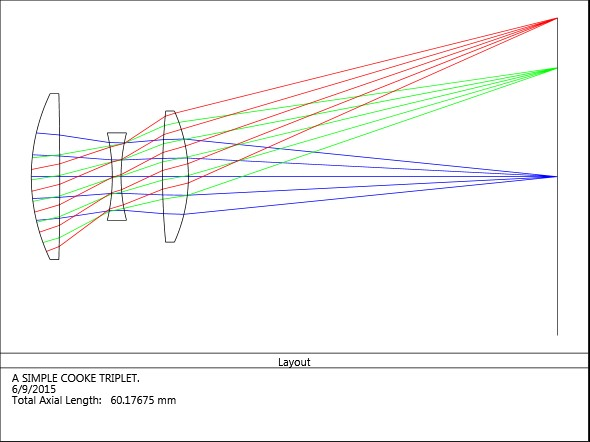

In [28]:
l.ipzCaptureWindowLQ(1)

Open FFT MTF analysis window

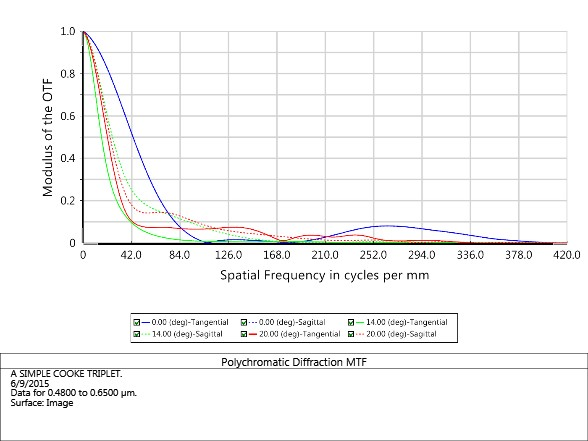

In [29]:
l.ipzCaptureWindowLQ(2)

Next, the FFT PSF analysis window was opened

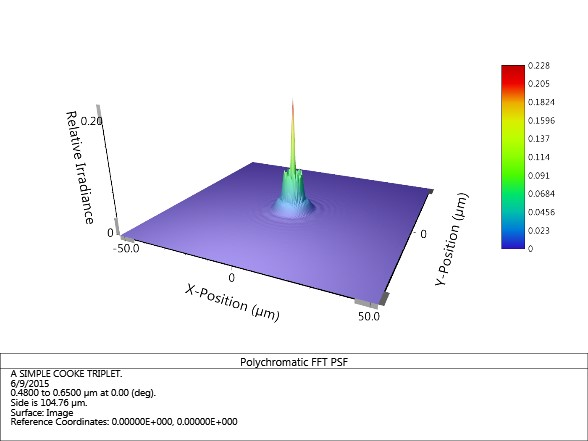

In [30]:
l.ipzCaptureWindowLQ(3)

A few others .... just for show

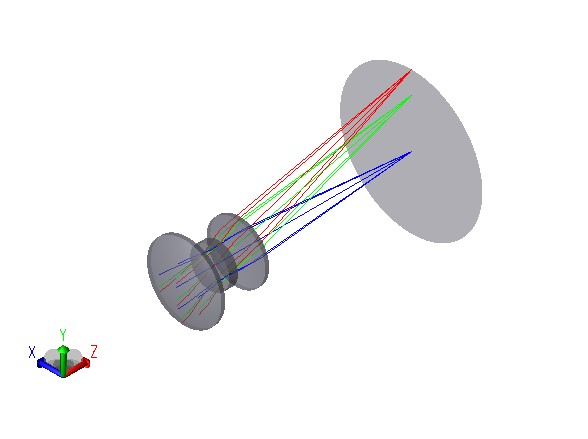

In [31]:
l.ipzCaptureWindowLQ(4) # Shaded Model

In [36]:
l.close()